In [12]:
%load_ext autoreload
%autoreload 2

import numpy
import pandas
from matplotlib import pyplot

import murefi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create mock data for testing

In [14]:
raw_data = pandas.DataFrame(columns='time,A01,A02,A03'.split(','))
raw_data.time = numpy.linspace(0, 30, 20)
for w, well in enumerate('A01,A02,A03'.split(',')):
    raw_data[well] = numpy.random.uniform() + numpy.random.normal((w+1) * raw_data.time, scale=0.2)
raw_data = raw_data.set_index('time')
raw_data.head()

,A01,A02,A03
time,,,
0.000000,0.917577,0.159198,0.208567
1.578947,2.132177,3.128472,5.080471
3.157895,4.218088,6.654950,9.808620
4.736842,5.433394,9.805893,14.636634
6.315789,6.750376,12.493139,19.294510


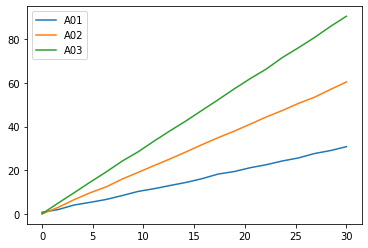

In [16]:
fig, ax = pyplot.subplots()

for col in raw_data.columns:
    ax.plot(raw_data.index, raw_data[col], label=col)
    
ax.legend()
pyplot.show()

## Now create `murefi` data structures
There are three types of data in `murefi`:
+ `Timeseries` is just a pair of vectors `x` and `y`
+ `Replicate` bundles multiple `Timeseries` into one realization of an experiment
+ `Dataset` contains many `Replicates` that are all independent of each other

With these data structures, every single measurement can (and should!) have its own timestamp. Also, all the `Timeseries` may have different lengths.

Now let's assume that the `raw_data` from above are trajectories of absorbance-values for three `Replicate`s.

In [25]:
dataset = murefi.Dataset()

# make a replicate for each well
for well in raw_data.columns:
    # create a Replicate object and name it after the well
    rep = murefi.Replicate(iid=well)
    # then fill it with the timeseries
    rep['A430'] = murefi.Timeseries(
        x=numpy.array(raw_data.index),
        y=numpy.array(raw_data[well]),
        # independent_key describes the dimension (e.g. X, S, P, acid, ...)
        # the dependent key is usually the unit of measurement
        independent_key='P', dependent_key='A430'
    )
    # finally, add the replicate to the dataset
    dataset[rep.iid] = rep
    
# by just printing out the dataset, its contents are summarized:
dataset

Dataset([('A01', Replicate(A430[:20])),
         ('A02', Replicate(A430[:20])),
         ('A03', Replicate(A430[:20]))])

## Using the data structures
`Dataset` and `Replicate` are dictionaries. They can be indexed with `[key]` and iterated over using `.items()`:

In [28]:
for rid, replicate in dataset.items():
    print(f'Replicate "{rid}" contains timeseries for: {set(replicate.keys())}')

Replicate "A01" contains timeseries for: {'A430'}
Replicate "A02" contains timeseries for: {'A430'}
Replicate "A03" contains timeseries for: {'A430'}


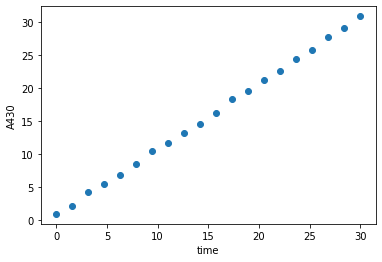

In [36]:
rep_A01 = dataset['A01']
A430_A01 = rep_A01['A430']

fig, ax = pyplot.subplots()

ax.set_xlabel('time')
ax.set_ylabel(A430_A01.dependent_key)
ax.scatter(A430_A01.x, A430_A01.y)

pyplot.show()